**CNNs on MNIST data set**

In [11]:
import torch
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from torchsummary import summary


In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [16]:
import pandas as pd

data = pd.read_csv('mnist_train.csv')

In [17]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
data.shape

(60000, 785)

In [20]:
#Transforming data to numpy arrays and extradting the first 10k samples
data = np.array(data)
data = data[0:10000,:]

X = data[:,1:]
y = data[:,0]

print(X.shape)

(10000, 784)


In [21]:
#Transforming to 4D
X = X.reshape(X.shape[0],1,28,28)
print(X.shape)

(10000, 1, 28, 28)


In [23]:
# Step 1 Convert to pytorch tensor
X_t   = torch.tensor( X, dtype = torch.float32 )
y_t = torch.tensor( y, dtype = torch.long)

# Step 2: Perform Train Test Split and Normalize the data
train_data, test_data, train_labels, test_labels = train_test_split(X_t, y_t, test_size = 0.1, random_state = 1478)

train_data = train_data/torch.max(train_data)
test_data  = test_data/torch.max(test_data)


# Step 3: Convert into PyTorch Datasets
X_train = TensorDataset(train_data,train_labels)
X_test  = TensorDataset(test_data,test_labels)


# Step 4: Move the data into dataloader objects
batchsize    = 32
train_loader = DataLoader(X_train, batch_size = batchsize, shuffle = True, drop_last=True)
test_loader  = DataLoader(X_test, batch_size = X_test.tensors[0].shape[0])

In [24]:
for X,y in train_loader:
  break
print(X.shape)
print(" ")
print(y.shape)

torch.Size([32, 1, 28, 28])
 
torch.Size([32])


In [25]:
#Creating the CNN

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Defining Convolution Layers

        self.conv1 = nn.Conv2d(1, 10, 5, 1, 1)
        # 1 = channel,   10 = number of kernels,    5 = kernel_size,    1 = Stride,     1 = padding

        # size = (28 - 5 + 2*1)/1 )+1 = 26  after convolution
        # size = 26/2 = 13   after max pooling

        self.conv2 = nn.Conv2d(10, 20, 5, 1, 1)
        # 10 = channels or featuremaps

        # size= (13-5+2*1)/1 )+1 = 11
        # size = 11/2 = np.floor(5.5) = 5   after max pooling

        # There are 20 kernels in the conv layer before the FC Layer
        # The dim of feature map after conv2 and max pooling will be 5*5*20
        # We have 20 feature maps each of size 5 x 5.

      # Defining FC layer and output (classification) layer

        self.fc = nn.Linear(5*5*20, 64)
        self.output = nn.Linear(64,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*20) # Infer the first dimension
        X = self.fc(X)
        X = F.relu(X)
        X = self.output(X)
        return X

In [26]:
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=500, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [27]:
#Count the total number of parameters in the model
summary(model.cuda(),(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 64]          32,064
            Linear-4                   [-1, 10]             650
Total params: 37,994
Trainable params: 37,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.14
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [28]:
#Training and Testing the model

epochs = 41

# loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01)

model.to(device) # placing a model on GPU

  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# loop over epochs

for epoch in range(epochs):
 model.train()

 # loop over training data batches

 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = model(X)
  loss = lossfunc(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)
# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 model.eval()
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): #This step  Deactivating autogradient
  ypred = model(X)
  ypred = ypred.cpu()
  y = y.cpu()

 # Appending test accuracy

  testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
  if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.07
 epochs : 10  loss :  0.01
 epochs : 20  loss :  0.00
 epochs : 30  loss :  0.00
 epochs : 40  loss :  0.00


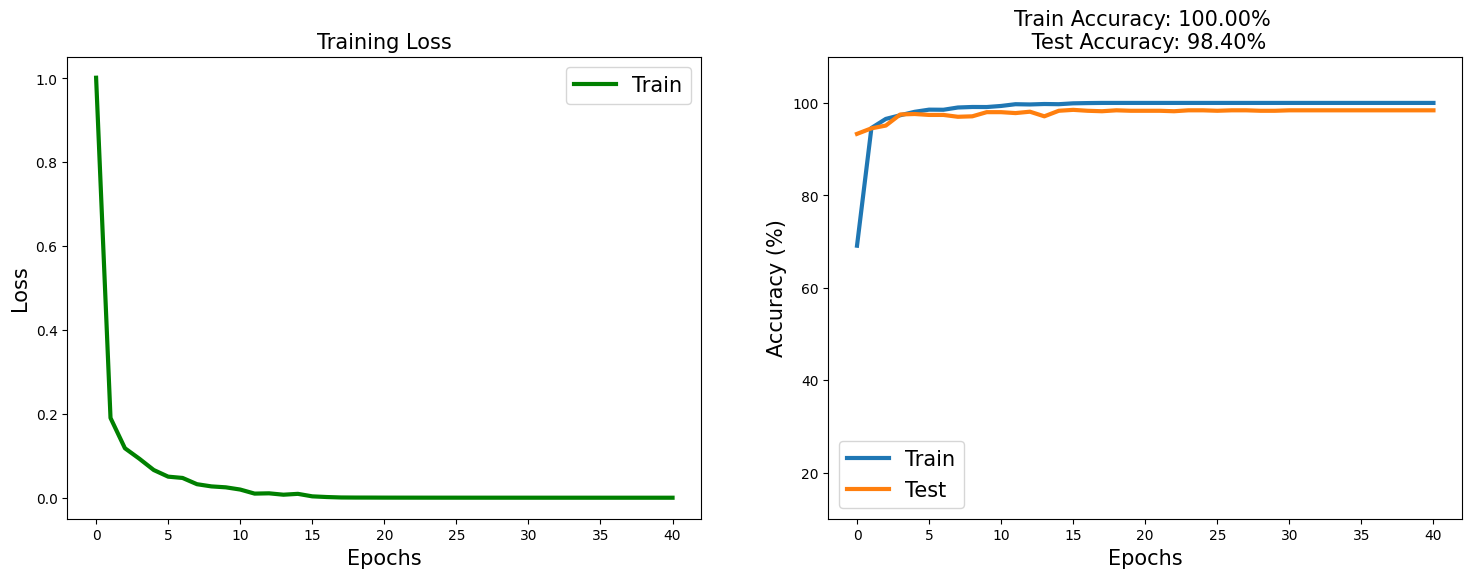

In [31]:
style.use('default')
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()